<a href="https://colab.research.google.com/github/iBakeHoNey/Thesis22-23/blob/main/UKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=8802050c51c8e56a88b28285feb6aeb77404a319a7251cd78c2cbab62064b925
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [2]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import matplotlib.pyplot as plt

In [3]:
def transp(time, x, u):
    # Medium-sized transport aircraft, longitudinal dynamics.
    S = 2170.0; CBAR = 17.5; MASS = 5.0E3; IYY = 4.1E6;
    TSTAT = 6.0E4; DTDV = -38.0; ZE = 2.0;  CDCLS = 0.042;
    CLA = 0.085; CMA = -0.022; CMDE = -0.016;     # per degree
    CMQ = -16.0; CMADOT = -6.0; CLADOT = 0.0;     # per radian
    RTOD = 57.29578; GD = 32.17;

    THTL = u[0]
    ELEV = u[1]
    XCG = u[2]
    LAND = u[3]

    VT = x[0]             # True airspeed in fps
    ALPHA = RTOD * x[1]   # AOA
    THETA = x[2]          # Pitch Rate
    Q = x[3]              # Pitch Altitude
    H = x[4]              # Altitude

    T, RHO, MACH, QBAR, PS = ADC(VT, H)
    QS = QBAR * S
    SALP = np.sin(x[1]); CALP = np.cos(x[1])
    GAM = THETA - x[1]
    SGAM = np.sin(GAM); CGAM = np.cos(GAM)

    if LAND == 0:
        CLO = 0.20; CDO = 0.016;
        CMO = 0.05; DCDG = 0.0; DCMG = 0.0
    elif LAND == 1:
        CLO = 1.0; CDO = 0.08;
        CMO = -0.20; DCDG = 0.02; DCMG = -0.05
    #else:
        #raise ValueError('Landing Gear & Flaps?')

    THR = (TSTAT + VT * DTDV) * max(THTL, 0)                          # Thrust
    CL = CLO + CLA * ALPHA                                            # Lift
    CM = DCMG + CMO + CMA * ALPHA + CMDE * ELEV + CL * (XCG - 0.25)   # Moment
    CD = DCDG + CDO + CDCLS * CL * CL                                 # Drag

    # State Equations
    xd = np.zeros(5)
    xd[0] = (THR * CALP - QS * CD) / MASS - GD * SGAM
    xd[1] = (-THR * SALP - QS * CL + MASS * (VT * Q + GD * CGAM)) / (MASS * VT + QS * CLADOT)
    xd[2] = Q
    D = 0.5 * CBAR * (CMQ * Q + CMADOT * xd[1]) / VT
    xd[3] = (QS * CBAR * (CM + D) + THR * ZE) / IYY
    xd[4] = VT * SGAM

    return xd, CD, CL, CM

In [4]:
def ADC(VT, ALT):
    R0 = 2.377E-3                 # Sea-level density
    TFAC = 1.0 - 0.703E-5 * ALT
    T = 519.0 * TFAC              # Temperature
    if ALT >= 35000.0:
        T = 390.0
    RHO = R0 * (TFAC**4.14)       # Density
    AMACH = VT / np.sqrt(1.4 * 1716.3 * T)  # Mach no.
    QBAR = 0.5 * RHO * VT**2      # Dynamic Pressure
    PS = 1715.0 * RHO * T         # Static Pressure

    return T, RHO, AMACH, QBAR, PS

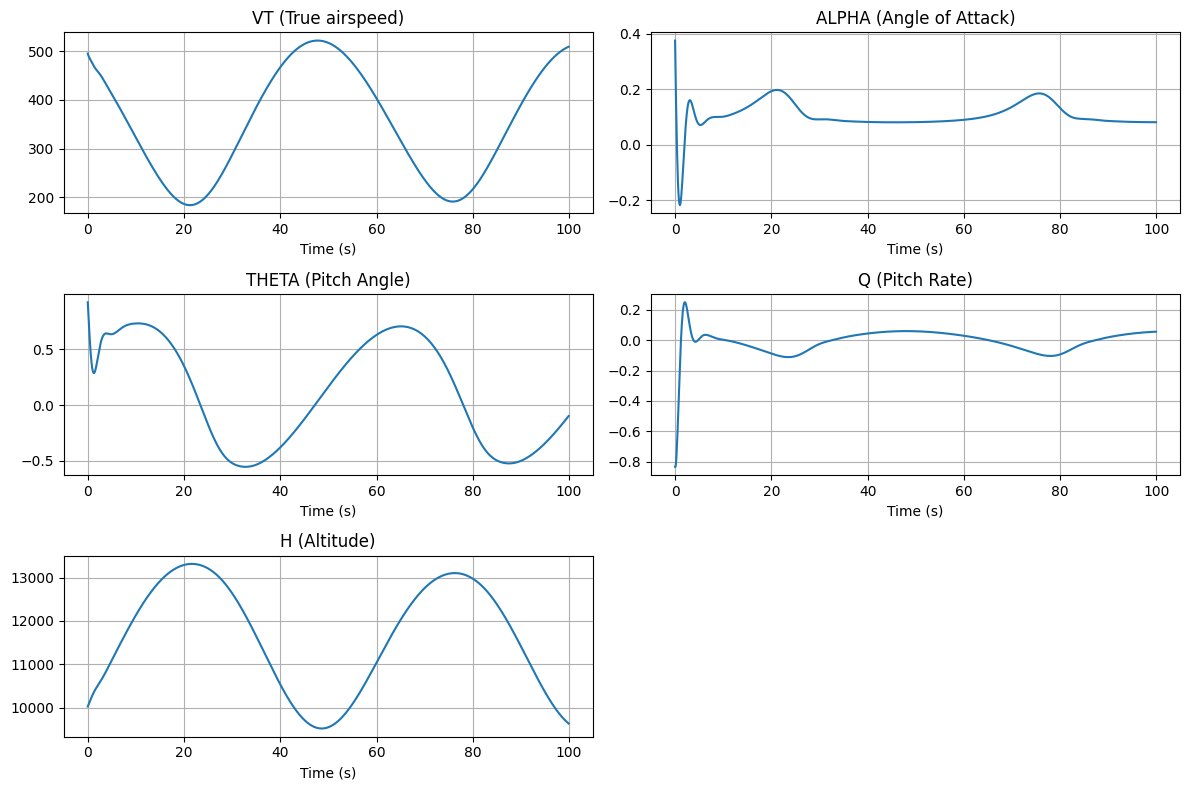

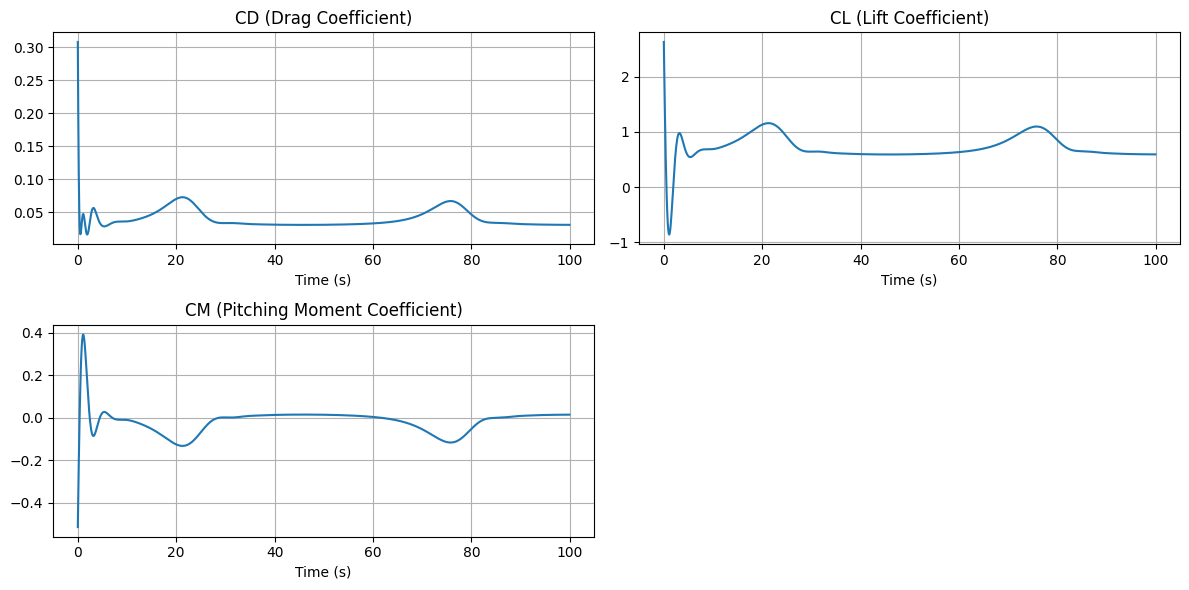

In [5]:
# Simulation settings
duration = 100.0
dt = 0.1
num_steps = int(duration/dt)

# Initial conditions
x = np.array([500.0, 0.5, 1, -0.8, 10000])  # [VT, ALPHA, THETA, Q, H]
u = np.array([0.204, -4.1, 0.25, 0])  # [THTL, ELEV, XCG, LAND]

# Storing history for plotting or analysis
x_history = np.zeros((num_steps, len(x)))
CD_history = np.zeros(num_steps)
CL_history = np.zeros(num_steps)
CM_history = np.zeros(num_steps)

for step in range(num_steps):
    xd, CD, CL, CM = transp(step*dt, x, u)

    # Euler integration step
    x = x + xd * dt
    CD_history[step] = CD
    CL_history[step] = CL
    CM_history[step] = CM

    # Store state for future reference or plotting
    x_history[step, :] = x

# Plotting the states
time_array = np.arange(0, duration, dt)
state_names = ['VT (True airspeed)', 'ALPHA (Angle of Attack)', 'THETA (Pitch Angle)', 'Q (Pitch Rate)', 'H (Altitude)']

plt.figure(figsize=(12, 8))
for i, name in enumerate(state_names):
    plt.subplot(3, 2, i+1)
    plt.plot(time_array, x_history[:, i])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CD, CL, CM values
coeff_names = ['CD (Drag Coefficient)', 'CL (Lift Coefficient)', 'CM (Pitching Moment Coefficient)']
coeff_values = [CD_history, CL_history, CM_history]

plt.figure(figsize=(12, 6))
for i, name in enumerate(coeff_names):
    plt.subplot(2, 2, i+1)
    plt.plot(time_array, coeff_values[i])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
x_history[999,:]

array([ 5.09773847e+02,  8.07860088e-02, -9.81475200e-02,  5.48682685e-02,
        9.63057051e+03])

In [7]:
def transp_ukf(x, dt, u):
    xd, CD, CL, CM = transp(0, x, u)
    return x + xd * dt

In [8]:
# Measurement function: [VT, THETA, Q, H]
def hx(x):
    return np.array([x[0], x[2], x[3], x[4]])

# Create UKF
sigmas = MerweScaledSigmaPoints(5, alpha=0.5933, beta= 0.1630, kappa=0.6391)
ukf = UKF(dim_x=5, dim_z=4, dt=dt, fx=transp_ukf, hx=hx, points=sigmas)
#ukf.x = np.array([500.0, 0.5, 1, -0.8, 10000])  # initial state
ukf.x = np.array([5.09773847e+02, 8.07860088e-02, -9.81475200e-02, 5.48682685e-02, 9.63057051e+03])  # initial state
ukf.P = np.eye(5) * 1  # initial state covariance
ukf.R = np.diag([2, 0.1, 0.1, 2])  # measurement noise
ukf.Q = np.eye(5) * 0.1  # process noise

In [9]:
alpha_estimation = []

for step in range(num_steps):
    # Simulate "true" system behavior using the provided function
    xd, CD, CL, CM = transp(step*dt, x, u)
    x = x + xd * dt

    # Generate a "measurement" which includes noise
    z = hx(x) + np.random.normal(size=(4,))*[1, 0.005, 0.005, 1]

    # Predict next state with UKF
    ukf.predict(u=u)

    # Update UKF with measurement
    ukf.update(z)

    # Store estimated ALPHA for plotting
    alpha_estimation.append(ukf.x[1])

    # Store true states and coefficients for future reference or plotting
    x_history[step, :] = x
    CD_history[step] = CD
    CL_history[step] = CL
    CM_history[step] = CM

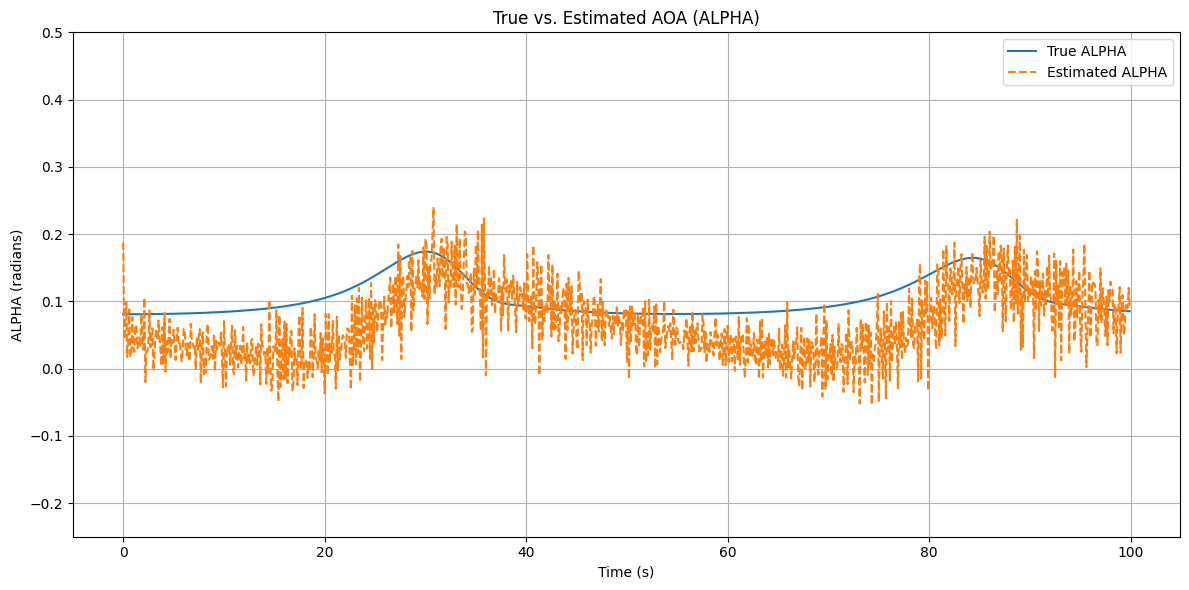

In [10]:
# Convert alpha_estimation list to a numpy array for convenience
alpha_estimation = np.array(alpha_estimation)

# Plotting the true vs. estimated ALPHA (Angle of Attack)
plt.figure(figsize=(12, 6))
plt.plot(time_array, x_history[:, 1], label='True ALPHA')
plt.plot(time_array, alpha_estimation, label='Estimated ALPHA', linestyle='--')
plt.title('True vs. Estimated AOA (ALPHA)')
plt.xlabel('Time (s)')
plt.ylabel('ALPHA (radians)')
plt.ylim(-0.25,0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

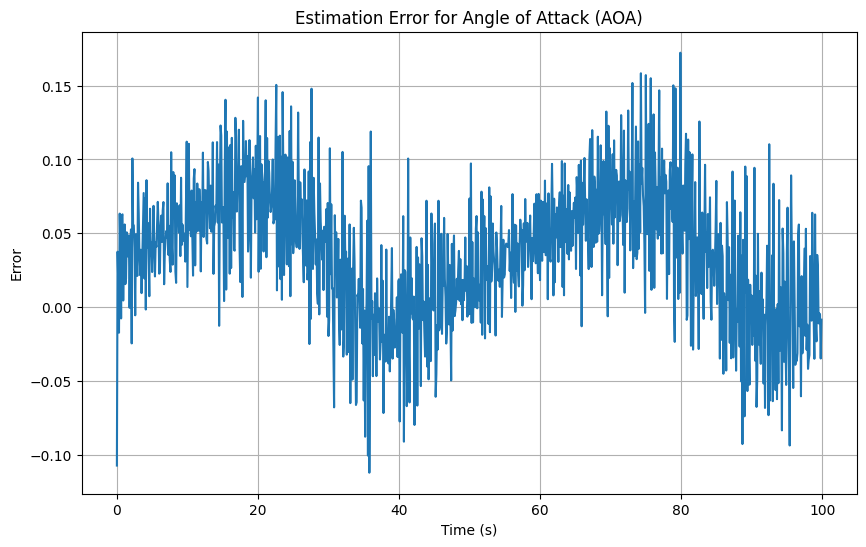

In [11]:
aoa_true = x_history[:, 1]
aoa_estimation = np.array(alpha_estimation)
aoa_error = aoa_true - aoa_estimation

plt.figure(figsize=(10, 6))
plt.plot(time_array, aoa_error)
plt.title('Estimation Error for Angle of Attack (AOA)')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [12]:
import pandas as pd

# Assuming you've computed the error metrics as mentioned in the previous answer:
absolute_error = np.abs(aoa_true - aoa_estimation)
mae_aoa = np.mean(absolute_error)
rmse_aoa = np.sqrt(np.mean((aoa_true - aoa_estimation)**2))
mbd_aoa = np.mean(aoa_true - aoa_estimation)
std_dev_error = np.std(aoa_true - aoa_estimation)
percent_error = (absolute_error / aoa_true) * 100
mean_percent_error = np.mean(percent_error)

# Create a pandas DataFrame
df = pd.DataFrame({
    'Error Metric': ['Mean Absolute Error', 'RMSE', 'Mean Bias Deviation', 'Standard Deviation of Error', 'Mean Percent Error'],
    'Value': [mae_aoa, rmse_aoa, mbd_aoa, std_dev_error, mean_percent_error]
})

print(df)


                  Error Metric      Value
0          Mean Absolute Error   0.049251
1                         RMSE   0.059507
2          Mean Bias Deviation   0.037026
3  Standard Deviation of Error   0.046584
4           Mean Percent Error  49.204598


In [13]:
def ADC(VT, ALT):
    R0 = 2.377E-3
    TFAC = 1.0 - 0.703E-5 * ALT
    T = np.where(ALT >= 35000.0, 390.0, 519.0 * TFAC)  # Use np.where to handle arrays
    RHO = R0 * (TFAC**4.14)
    return RHO  # Return the values as needed

# Variables from the provided transp function:
S = 2170.0
CLO = 0.20; CDO = 0.016; CLA = 0.085; CDCLS = 0.042; DCDG = 0.0

# Using the true angle of attack values:
CL_true = CLO + CLA * aoa_true
CD_true = DCDG + CDO + CDCLS * CL_true * CL_true

# Using the estimated angle of attack values:
CL_estimated = CLO + CLA * aoa_estimation
CD_estimated = DCDG + CDO + CDCLS * CL_estimated * CL_estimated

# Compute density using the ADC function:
RHO = ADC(x_history[:, 0], x_history[:, 4])

# Compute the true and estimated lift and drag forces:
Lift_true = 0.5 * RHO * x_history[:, 0]**2 * S * CL_true
Drag_true = 0.5 * RHO * x_history[:, 0]**2 * S * CD_true
Lift_estimated = 0.5 * RHO * x_history[:, 0]**2 * S * CL_estimated
Drag_estimated = 0.5 * RHO * x_history[:, 0]**2 * S * CD_estimated


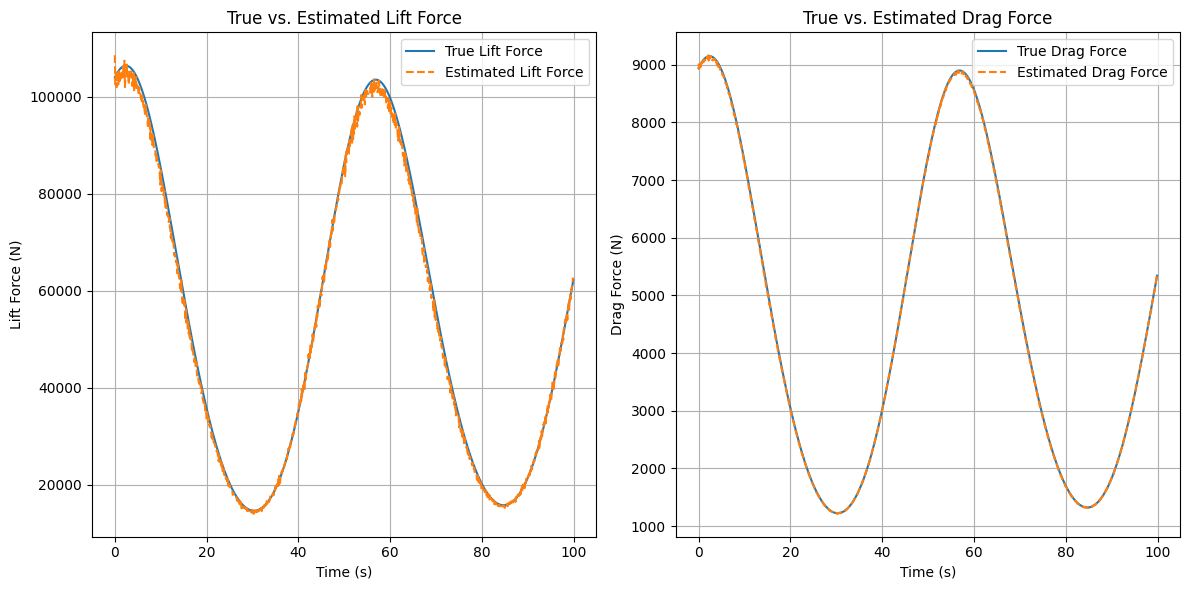

In [14]:
plt.figure(figsize=(12, 6))

# Lift comparison
plt.subplot(1, 2, 1)
plt.plot(time_array, Lift_true, label='True Lift Force')
plt.plot(time_array, Lift_estimated, linestyle='--', label='Estimated Lift Force')
plt.title('True vs. Estimated Lift Force')
plt.xlabel('Time (s)')
plt.ylabel('Lift Force (N)')
plt.legend()
plt.grid(True)

# Drag comparison
plt.subplot(1, 2, 2)
plt.plot(time_array, Drag_true, label='True Drag Force')
plt.plot(time_array, Drag_estimated, linestyle='--', label='Estimated Drag Force')
plt.title('True vs. Estimated Drag Force')
plt.xlabel('Time (s)')
plt.ylabel('Drag Force (N)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
Lift_error = Lift_true - Lift_estimated
Drag_error = Drag_true - Drag_estimated

# Error metrics
mae_lift = np.mean(np.abs(Lift_error))
rmse_lift = np.sqrt(np.mean(Lift_error**2))
mae_drag = np.mean(np.abs(Drag_error))
rmse_drag = np.sqrt(np.mean(Drag_error**2))

print(f"Lift Error: MAE = {mae_lift:.2f}, RMSE = {rmse_lift:.2f}")
print(f"Drag Error: MAE = {mae_drag:.2f}, RMSE = {rmse_drag:.2f}")


Lift Error: MAE = 1049.07, RMSE = 1384.44
Drag Error: MAE = 18.10, RMSE = 23.78
